In [22]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

!pip install pyLDAvis
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [23]:

#1) Downgrade NumPy to 1.26.x
!pip install numpy==1.26.0 --upgrade

# 2) Force-reinstall Gensim so it compiles against the new NumPy
!pip install --upgrade --force-reinstall gensim

# !pip install  gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 k

In [24]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [25]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [26]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [27]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.0 MB/s eta 0:00:00


In [28]:

# import nltk
# nltk.download('punkt_tab')
# !pip install -U spacy torch transformers
import spacy


In [29]:
# !python -m spacy download en_core_web_trf


In [30]:
df.shape[0]

87034

In [31]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [32]:
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [33]:
df.shape[0]

86446

In [34]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'mild pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
# start_date = '2021-11-01'
# end_date = '2022-01-31'

start_date = '2022-11-01'
end_date = '2023-01-31'
# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-34-49ea9e575302>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
63040,2023-01-02,mild pos,0.577042,flown disagree supposed fall asleep right away...,"[fly, disagree, suppose, fall, asleep, right, ...",fly disagree suppose fall asleep right away ea...
63091,2023-01-02,mild pos,0.667171,application approved global entry tried make a...,"[application, approve, global, entry, try, app...",application approve global entry try appointme...
63110,2023-01-01,mild pos,0.736473,dallas isnt walkable short uber almost everyth...,"[dallas, walkable, short, uber, restaurant, ho...",dallas walkable short uber restaurant hotel ca...
63128,2023-01-01,mild pos,0.664399,really system designed weed thing considered x...,"[system, design, weed, thing, consider, value,...",system design weed thing consider value chase ...
63164,2023-01-01,mild pos,0.722994,able book eventually successful australian cal...,"[able, book, eventually, successful, australia...",able book eventually successful australian center


In [35]:
high_pos_df.shape[0]

1582

       token  count
0       good    496
1     flight    492
2      point    408
3       book    323
4      thank    269
5       like    266
6        fly    257
7       well    246
8       time    236
9       look    186
10   airline    182
11     think    180
12    travel    178
13      find    174
14       day    167
15       way    163
16  business    162
17      seat    156
18     great    150
19      trip    149
20        go    148
21       get    142
22     hotel    137
23      mile    135
24      know    130
25      year    129
26      want    129
27     class    125
28     check    121
29    ticket    120


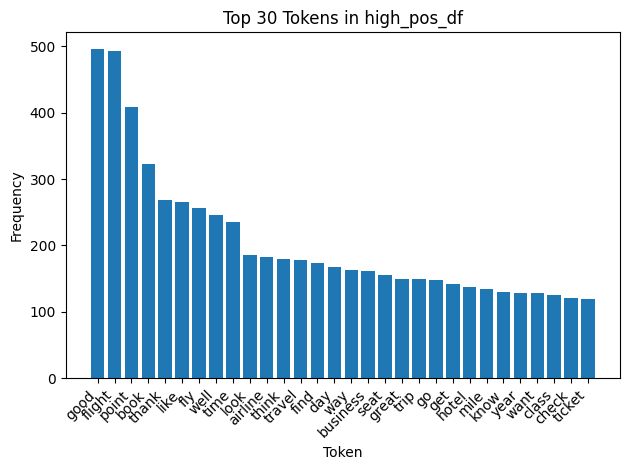

In [36]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [37]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


30429 words total, with a vocabulary size of 4377
Max reddit post length is 166 tokens
Mean reddit post length is 19.23 tokens
Median reddit post length is 13 tokens


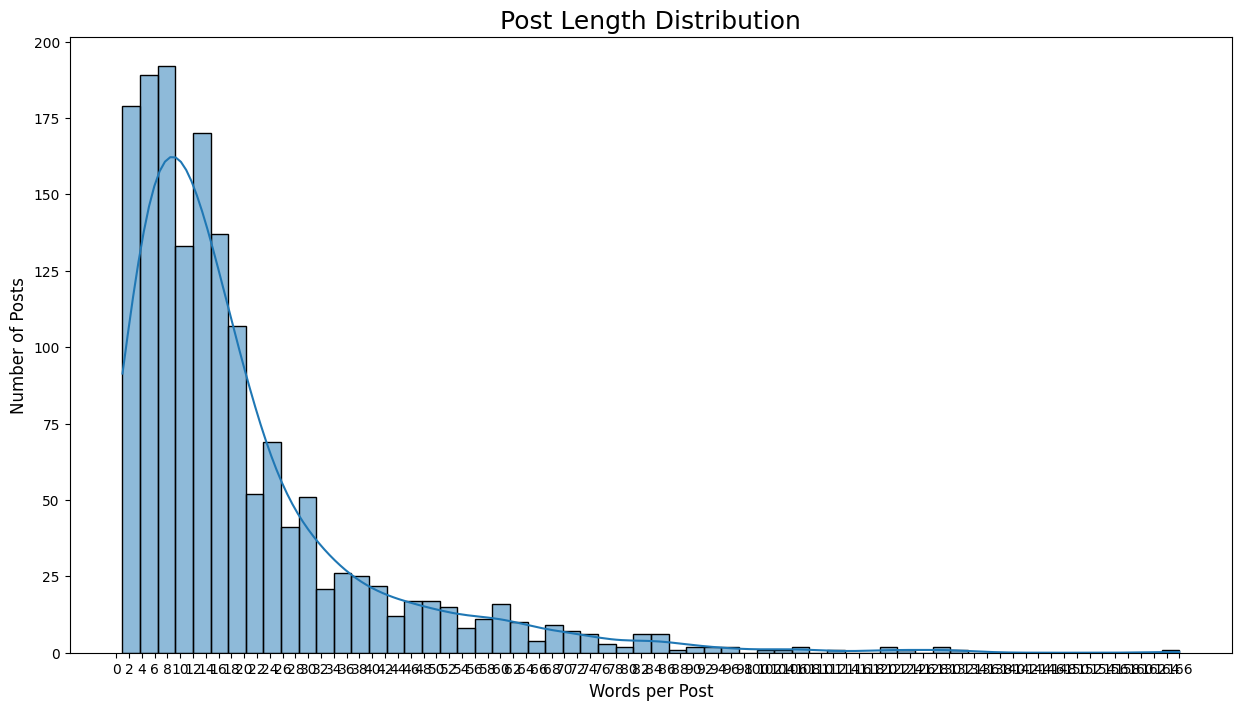

In [38]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [39]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim



In [40]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

#    min_count=3 → only consider pairs that appear in ≥3 docs
#    threshold=50 → higher threshold = fewer, more confident bigrams
# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


In [ ]:
high_pos_df.head()

In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_bigrams = itertools.chain.from_iterable(high_pos_df['bigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
bigram_counts = Counter(
    token for token in all_bigrams
    if isinstance(token, str) and token.count('_') == 1
)

# 3) How many unique trigrams?
total_unique_bigrams = len(bigram_counts)
print(f"Total number of unique bigrams: {total_unique_bigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count:,}")


In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=200,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel
# #
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 5)
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta, seed))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']



print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_4th_mild_pos.txt', 'w') as f:
    ...
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")


files.download('lda_model_full_summary_4th_mild_pos.txt')



In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [ ]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



In [ ]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()


In [ ]:
# import gensim.corpora as corpora
# # # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# # ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# # #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50, 100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
#     # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

# print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
#       f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']


# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [ ]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [ ]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [ ]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [ ]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [ ]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [3]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [4]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'mild neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
# start_date = '2021-11-01'
# end_date = '2022-01-31'
start_date = '2022-11-01'
end_date = '2023-01-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

NameError: name 'df' is not defined

In [ ]:
high_neg_first_wave_df.shape[0]

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [ ]:
#!pip install  gensim


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


In [ ]:
high_neg_first_wave_df.head()

In [5]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

NameError: name 'high_neg_first_wave_df' is not defined

In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                           chunksize=250,
#                                        passes=100,
#                                         iterations= 200,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [300]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta, seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

In [6]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


NameError: name 'LdaModel' is not defined

In [7]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_4th_mild_neg.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")
    f.flush()  # Ensure it's written to disk
# 3. Trigger the download
files.download('lda_model_full_summary_4th_mild_neg.txt')


NameError: name 'opt_coh' is not defined

In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [ ]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



In [ ]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()


In [8]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [9]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [10]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [11]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [12]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [13]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [14]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [15]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [16]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'mild neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
# start_date = '2021-11-01'
# end_date = '2022-01-31'

start_date = '2022-11-01'
end_date = '2023-01-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

NameError: name 'df' is not defined

In [ ]:
high_neu_first_wave_df.shape[0]

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)  # Adjust the step size as needed
plt.xticks(xticks)
plt.show()

In [ ]:
!pip install  gensim

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


In [ ]:
high_neu_first_wave_df.head()

In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

In [ ]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


In [ ]:
#import gensim.corpora as corpora
# Create Dictionary
#id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#    (Optional) Re-map the remaining token IDs to remove gaps
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [17]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [18]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [19]:
high_neu_first_wave_df.head()

NameError: name 'high_neu_first_wave_df' is not defined

In [ ]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta', 'seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


In [ ]:
lda_opt.save('/content/drive/MyDrive/lda_model_neutral_4th_wave.gensim')


In [ ]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_1st_mild_neu.txt')


In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [ ]:
# Cell 1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Cell 2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



In [ ]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()

#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [ ]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [ ]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [ ]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [ ]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [ ]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [ ]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [ ]:
# ## FIND THE OPTIMAL TOPIC

# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd

# # Assuming high_neu_first_wave_df['lemmatized_bigrams'] contains lists of lemmatized bigram tokens
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Create a Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus,
#                                        id2word=dictionary,
#                                        num_topics=num_topics,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)
#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#     return perplexity, coherence

# # Testing different numbers of topics
# results = []
# for num_topics in range(2, 12):  # You can adjust the range based on your needs
#     perplexity, coherence = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics)
#     results.append((num_topics, perplexity, coherence))

# # Display results
# print("Num Topics | Perplexity | Coherence")
# for result in results:
#     print(f"{result[0]:10d} | {result[1]:10.4f} | {result[2]:10.4f}")

# # Optional: find the number of topics with the highest coherence
# optimal_num_topics = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
# print(f"Optimal Number of Topics: {optimal_num_topics}")


In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()